In [1]:
# Imports
# pip install kagglehub[pandas-datasets]
#import kagglehub
#from kagglehub import KaggleDatasetAdapter
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np


import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import Counter

# DATA

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the data(images)
x_npz = np.load("../../data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("../../data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print("x = ", np.array(X).shape)
print("Y = ", np.array(Y).shape)

# Separete the data into train and test sets
# 80% train, 20% test
x_train_old, x_test, y_train_old, y_test = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

x_train_aux = np.load("../../data/x_images_arrays_under_train_over.npz")
x_train = x_train_aux["arr_0"]
y_train_aux = np.load("../../data/y_labels_arrays_under_train_over.npz")
y_train = y_train_aux["arr_0"]

#x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print("\nForma dos dados de treino:", np.array(x_train).shape) # (3045, 128, 128, 3)
print("Distribuição train antes:", Counter(y_train)) #np.int64(0): 2435, np.int64(2): 402, np.int64(1): 208
#print(np.array(x_val).shape)
print("Forma dos dados de teste:", np.array(x_test).shape) # (762, 128, 128, 3)
print("Distribuição test antes:", Counter(y_test)) #np.int64(0): 609, np.int64(2): 101, np.int64(1): 52

# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train = CustomImageDataset(x_train, y_train, transform=transform)
#dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_test, y_test, transform=transform)

img, label = dataset_train[0]
print("\nForma do img e label:", img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print("Quantidade dados de treino:", dataset_train.__len__()) # 610 images
#print(dataset_val.__len__()) # 0 images
print("Quantidade dados de teste:", dataset_test.__len__()) # 762 images

# Load into the DataLoader
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


x =  (3807, 128, 128, 3)
Y =  (3807,)

Forma dos dados de treino: (1206, 128, 128, 3)
Distribuição train antes: Counter({np.int64(2): 402, np.int64(0): 402, np.int64(1): 402})
Forma dos dados de teste: (762, 128, 128, 3)
Distribuição test antes: Counter({np.int64(0): 609, np.int64(2): 101, np.int64(1): 52})

Forma do img e label: torch.Size([1, 128, 128]) 2
Quantidade dados de treino: 1206
Quantidade dados de teste: 762


# NETWORK

### Define

In [3]:
# Define the network

# Already defined in the previous cell
# batch_size = 32
# train_loader / val_loader / test_loader
num_steps = 50

dtype = torch.float
# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Network Architecture 
num_inputs = 128*128
num_hidden = 1000
num_outputs = 3 # classes

# Temporal Dynamics
# num_steps = 25
#beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self): 
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        #self.relu2 = nn.ReLU()

    def forward(self, x):
        # Flatten input if necessary
        x = x.view(-1, num_inputs)
        
        # Forward pass through layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        #x = self.relu2(x) # tentar tirar
        #output = F.log_softmax(x, dim=1)  # Saída com log_softmax
        return x

# Load the network onto CUDA if available
net = Net().to(device)

In [9]:
# Metrics
# Accuracy
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output = net(data)
    _, idx = output.max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

# loss
# 1. Contar quantos exemplos de cada classe existem no dataset
# targets_list = []

# # Percorre todo o conjunto de treino para pegar os rótulos
# for _, targets in train_loader:
#     targets_list.extend(targets.tolist())

# class_counts = Counter(targets_list)
# total_samples = sum(class_counts.values())

# # 2. Calcular o peso inverso à frequência (quanto menos amostras, maior o peso)
# num_classes = len(class_counts)
# class_weights = []

# for i in range(num_classes):
#     count = class_counts[i]
#     weight = total_samples / (num_classes * count)
#     class_weights.append(weight)

# # 3. Criar tensor e mover para o mesmo dispositivo da rede
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# 4. Redefinir a função de perda com pesos
# loss = nn.CrossEntropyLoss(weight=class_weights)

# Total samples
# total = 402 + 208 + 402

# # Frequência relativa inversa
# w0 = total / (3 * 402)
# w1 = total / (3 * 208)
# w2 = total / (3 * 402)

# # Tensor com pesos
# weights = torch.tensor([w0, w1, w2], dtype=torch.float).to(device)

# # Loss ponderado
# loss = nn.CrossEntropyLoss(weight=weights)

# Class-Balanced Loss
# beta = 0.999
# class_counts = [402, 208, 402]
# effective_num = [(1 - beta) / (1 - beta ** count) for count in class_counts]
# weights = torch.tensor(effective_num, dtype=torch.float).to(device)
# loss = nn.CrossEntropyLoss(weight=weights)

loss = nn.CrossEntropyLoss()  # Sem pesos, pois o dataset já está balanceado

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

### Training Loop

In [22]:
# Training loop
num_epochs = 32
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        #print(epoch, iter_counter, counter)
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        #spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
        #print(f"Spike data size (latency 2): {spike_data.size()}")

        output = net(data)

        # Calculate loss
        loss_val = loss(output, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_output = net(test_data)

            # Test set loss
            test_loss = loss(test_output, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 32 == 0:
                train_printer()
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss: 0.92
Test Set Loss: 0.91
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 46.88%


Epoch 0, Iteration 32
Train Set Loss: 0.87
Test Set Loss: 1.21
Train set accuracy for a single minibatch: 65.62%
Test set accuracy for a single minibatch: 18.75%


Epoch 1, Iteration 26
Train Set Loss: 0.89
Test Set Loss: 1.09
Train set accuracy for a single minibatch: 59.38%
Test set accuracy for a single minibatch: 43.75%


Epoch 2, Iteration 20
Train Set Loss: 0.87
Test Set Loss: 1.13
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 31.25%


Epoch 3, Iteration 14
Train Set Loss: 0.99
Test Set Loss: 1.06
Train set accuracy for a single minibatch: 46.88%
Test set accuracy for a single minibatch: 56.25%


Epoch 4, Iteration 8
Train Set Loss: 0.79
Test Set Loss: 0.71
Train set accuracy for a single minibatch: 68.75%
Test set accuracy for a single minibatch: 68.75%


Epoch 5, Iteration

In [ ]:
# Código extra para salvar o modelo
PATH = '../../models/ann_full_32_under_class_weights_over.pth'
torch.save(net.state_dict(), PATH)
print(f"Modelo salvo com sucesso em: {PATH}")

Modelo salvo com sucesso em: ../../models/ann_full_4_under.pth


### Metrics

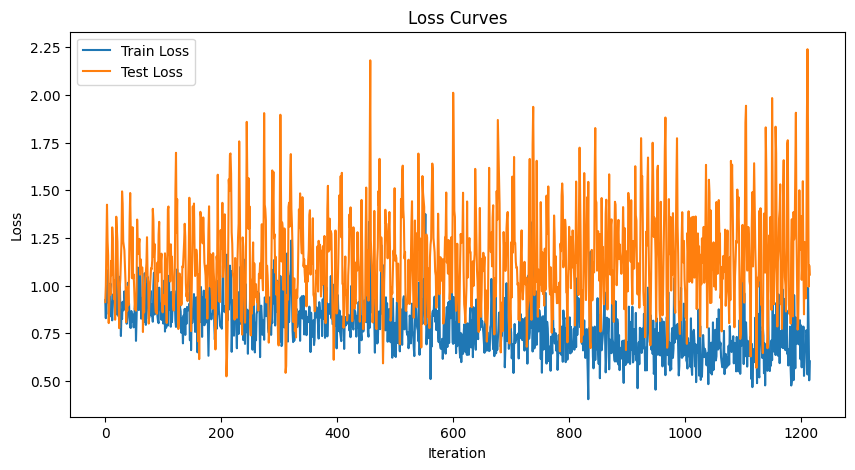

In [23]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [24]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro') # average = 'weighted' | 'micro' | 'macro'
    return precision, recall, f1

# Listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_targets = []

# Avaliação do modelo
total = 0
correct = 0

with torch.no_grad():
    net.eval()
    for data_2, targets_2 in test_loader:
        data_2 = data_2.to(device)
        targets_2 = targets_2.to(device)

        # Test set forward pass
        test_output_2 = net(data_2)

        # Previsões
        _, predicted = test_output_2.max(1)
        
        # Acumular acurácia
        total += targets_2.size(0)
        correct += (predicted == targets_2).sum().item()

        # Armazenar previsões e rótulos para F1 e matriz de confusão
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets_2.cpu().numpy())

# Calcular acurácia
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# Calcular precisão, recall e F1-score
precision, recall, f1 = calculate_metrics(all_targets, all_preds) 
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Calcular e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão:")
print(conf_matrix)

Total correctly classified test set images: 397/762
Test Set Accuracy: 52.10%
Precision: 0.37
Recall: 0.40
F1-score: 0.34

Matriz de Confusão:
[[335  43 231]
 [ 19   4  29]
 [ 39   4  58]]


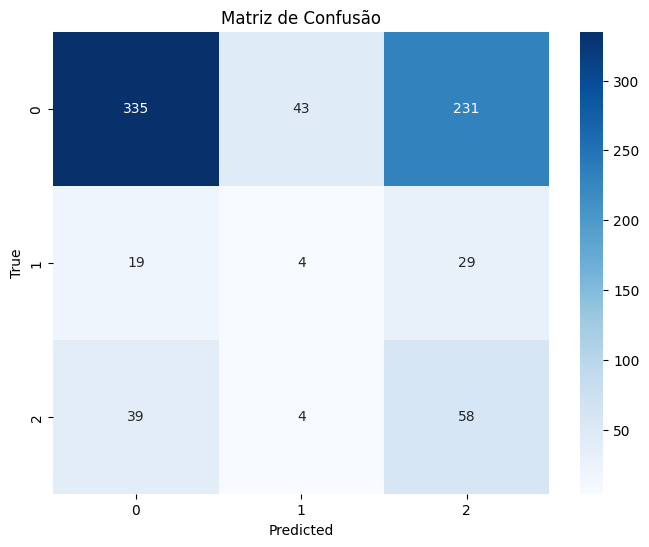

In [25]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()